# LSTM Feature Importance
- 참고자료 <br>
https://www.kaggle.com/cdeotte/lstm-feature-importance

In [19]:
import numpy as np, os
import pandas as pd

# import optuna

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717 
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display



In [25]:
keras

<module 'tensorflow.keras' from '/usr/local/lib/python3.8/dist-packages/tensorflow/keras/__init__.py'>

## DATA

In [20]:
import random    
seed_num = 48
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4069).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4069), (6182,), (1545, 10, 4069), (1545,))

In [21]:
COLS = list(pd.read_csv('/project/guri/data/data2d_forposter.csv').columns)
# COLS = COLS[:100]

In [22]:
DEBUG = False
TRAIN_MODEL = True
INFER_TEST = True
ONE_FOLD_ONLY = True
COMPUTE_LSTM_IMPORTANCE = True

EPOCH = 300
BATCH_SIZE = 1024
NUM_FOLDS = 10

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = X_train[train_idx], X_train[test_idx]
        y_train, y_valid = y_train[train_idx], y_train[test_idx]
        
        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])),
                keras.layers.LSTM(128, activation='hard_sigmoid', return_sequences=True),
                keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True),
                keras.layers.Dropout(0.2),
                keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True),
                keras.layers.LSTM(32, activation='hard_sigmoid', return_sequences=False),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer="adam", loss="mae")

            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min", restore_best_weights=True)
            sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
            
        else:
            model = keras.models.load_model('./'+checkpoint_filepath)

        if INFER_TEST:
            print(' Predicting test data...')
            test_preds.append(model.predict(X_test,verbose=0).reshape(-1, 1))
                    
        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing LSTM feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds = model.predict(X_valid, verbose=0)
#             baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
            base_binary_crossentropy = keras.losses.binary_crossentropy(oof_preds, y_valid)
            results.append({'feature':'BASELINE','binary_crossentropy':base_binary_crossentropy}) 
#             results.append({'feature':'BASELINE','baseline_mae':baseline_mae}) 

            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_test[:,:,k].copy()
                np.random.shuffle(X_test[:,:,k])
                        
                # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                oof_preds = model.predict(X_test, verbose=0)
                binary_crossentropy = keras.losses.binary_crossentropy(oof_preds, y_valid)
#                 mae = np.mean(np.abs( oof_preds-y_valid ))
                results.append({'feature':COLS[k],'binary_crossentropy':binary_crossentropy})
#                 results.append({'feature':COLS[k],'mae':mae})
                X_test[:,:,k] = save_col
            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('binary_crossentropy')
            plt.figure(figsize=(10,20))
            plt.barh(np.arange(len(COLS)+1),df.binary_crossentropy)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('LSTM Feature Importance',size=16)
            plt.ylim((-1,len(COLS)+1))
            plt.plot([base_binary_crossentropy,base_binary_crossentropy],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\nMAE={base_binary_crossentropy:.5f}')
            plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
            plt.ylabel('Feature',size=14)
            plt.legend()
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'lstm_feature_importance_fold_{fold+1}.csv',index=False)
                               
        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY: break

--------------- > Fold 1 < ---------------
Epoch 1/300
6/6 [==============================] - 7s 384ms/step - loss: 0.4986 - val_loss: 0.4770

Epoch 00001: val_loss improved from inf to 0.47701, saving model to folds0.hdf5
Epoch 2/300
6/6 [==============================] - 2s 327ms/step - loss: 0.4697 - val_loss: 0.4401

Epoch 00002: val_loss improved from 0.47701 to 0.44009, saving model to folds0.hdf5
Epoch 3/300
6/6 [==============================] - 2s 338ms/step - loss: 0.4372 - val_loss: 0.4110

Epoch 00003: val_loss improved from 0.44009 to 0.41102, saving model to folds0.hdf5
Epoch 4/300
6/6 [==============================] - 2s 326ms/step - loss: 0.4199 - val_loss: 0.4002

Epoch 00004: val_loss improved from 0.41102 to 0.40018, saving model to folds0.hdf5
Epoch 5/300
6/6 [==============================] - 2s 333ms/step - loss: 0.4130 - val_loss: 0.3954

Epoch 00005: val_loss improved from 0.40018 to 0.39537, saving model to folds0.hdf5
Epoch 6/300
6/6 [========================

6/6 [==============================] - 2s 426ms/step - loss: 0.3962 - val_loss: 0.3803

Epoch 00089: val_loss improved from 0.38030 to 0.38029, saving model to folds0.hdf5
Epoch 90/300
6/6 [==============================] - 3s 428ms/step - loss: 0.3962 - val_loss: 0.3803

Epoch 00090: val_loss improved from 0.38029 to 0.38027, saving model to folds0.hdf5
Epoch 91/300
6/6 [==============================] - 3s 425ms/step - loss: 0.3962 - val_loss: 0.3803

Epoch 00091: val_loss improved from 0.38027 to 0.38026, saving model to folds0.hdf5
Epoch 92/300
6/6 [==============================] - 2s 407ms/step - loss: 0.3962 - val_loss: 0.3803

Epoch 00092: val_loss improved from 0.38026 to 0.38025, saving model to folds0.hdf5
Epoch 93/300
6/6 [==============================] - 2s 407ms/step - loss: 0.3961 - val_loss: 0.3802

Epoch 00093: val_loss improved from 0.38025 to 0.38024, saving model to folds0.hdf5
Epoch 94/300
6/6 [==============================] - 2s 395ms/step - loss: 0.3962 - val_l


Epoch 00131: val_loss improved from 0.38012 to 0.38012, saving model to folds0.hdf5
Epoch 132/300
6/6 [==============================] - 2s 365ms/step - loss: 0.3960 - val_loss: 0.3801

Epoch 00132: val_loss improved from 0.38012 to 0.38012, saving model to folds0.hdf5
Epoch 133/300
6/6 [==============================] - 2s 387ms/step - loss: 0.3960 - val_loss: 0.3801

Epoch 00133: val_loss improved from 0.38012 to 0.38012, saving model to folds0.hdf5
Epoch 134/300
6/6 [==============================] - 2s 367ms/step - loss: 0.3960 - val_loss: 0.3801

Epoch 00134: val_loss improved from 0.38012 to 0.38012, saving model to folds0.hdf5
Epoch 135/300
6/6 [==============================] - 2s 374ms/step - loss: 0.3960 - val_loss: 0.3801

Epoch 00135: val_loss improved from 0.38012 to 0.38012, saving model to folds0.hdf5
Epoch 136/300
6/6 [==============================] - 2s 369ms/step - loss: 0.3961 - val_loss: 0.3801

Epoch 00136: val_loss improved from 0.38012 to 0.38012, saving model 

Epoch 175/300
6/6 [==============================] - 2s 382ms/step - loss: 0.3960 - val_loss: 0.3801

Epoch 00175: val_loss improved from 0.38011 to 0.38011, saving model to folds0.hdf5
Epoch 176/300
6/6 [==============================] - 2s 378ms/step - loss: 0.3960 - val_loss: 0.3801

Epoch 00176: val_loss did not improve from 0.38011
Epoch 177/300
6/6 [==============================] - 2s 376ms/step - loss: 0.3960 - val_loss: 0.3801

Epoch 00177: val_loss improved from 0.38011 to 0.38011, saving model to folds0.hdf5
Epoch 178/300
6/6 [==============================] - 2s 379ms/step - loss: 0.3961 - val_loss: 0.3801

Epoch 00178: val_loss did not improve from 0.38011
Epoch 179/300
6/6 [==============================] - 2s 394ms/step - loss: 0.3960 - val_loss: 0.3801

Epoch 00179: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00179: val_loss improved from 0.38011 to 0.38011, saving model to folds0.hdf5
Epoch 180/300
6/6 [==============================] - 2

TypeError: Cannot convert 1e-07 to EagerTensor of dtype int64

In [14]:
df.sort_values('mae',ascending=False)

,feature,baseline_mae,mae
2704,8290036005,NaN,0.406037
104,50983,NaN,0.406037
1996,338004904,NaN,0.406037
279,51493,NaN,0.406037
3916,64253033335,NaN,0.406037
...,...,...,...
3089,51079012620,NaN,0.406037
1590,121065721,NaN,0.406037
175,51221,NaN,0.406037
207,51277,NaN,0.406037


# re

--------------- > Fold 1 < ---------------
Epoch 1/300
4/4 [==============================] - 5s 321ms/step - loss: 0.6825 - val_loss: 0.6747

Epoch 00001: val_loss improved from inf to 0.67466, saving model to folds0.hdf5
Epoch 2/300
4/4 [==============================] - 1s 223ms/step - loss: 0.6757 - val_loss: 0.6781

Epoch 00002: val_loss did not improve from 0.67466
Epoch 3/300
4/4 [==============================] - 1s 211ms/step - loss: 0.6794 - val_loss: 0.6736

Epoch 00003: val_loss improved from 0.67466 to 0.67361, saving model to folds0.hdf5
Epoch 4/300
4/4 [==============================] - 1s 219ms/step - loss: 0.6741 - val_loss: 0.6729

Epoch 00004: val_loss improved from 0.67361 to 0.67294, saving model to folds0.hdf5
Epoch 5/300
4/4 [==============================] - 1s 215ms/step - loss: 0.6724 - val_loss: 0.6729

Epoch 00005: val_loss improved from 0.67294 to 0.67287, saving model to folds0.hdf5
Epoch 6/300
4/4 [==============================] - 1s 217ms/step - loss: 0

  0%|          | 0/4069 [00:00<?, ?it/s]

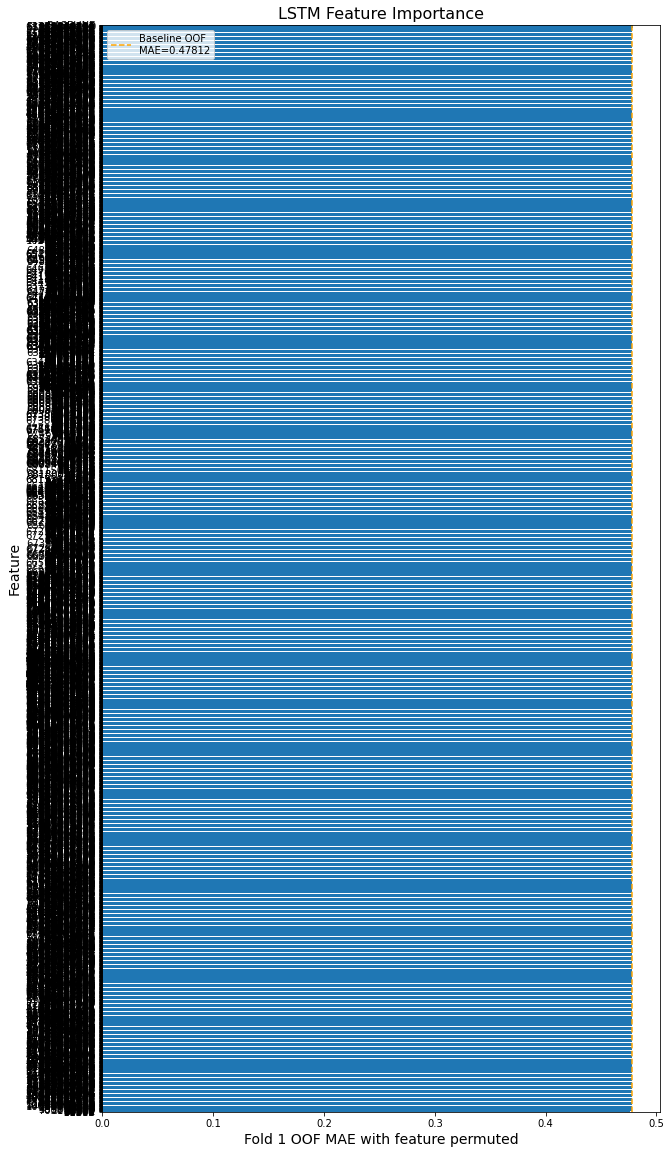

In [18]:
DEBUG = False
TRAIN_MODEL = True # True하면 실행한게 저장됨, 1번째 돌렸을 때만 저장해. 그 뒤엔 False로 바꿔
INFER_TEST = True
ONE_FOLD_ONLY = True
COMPUTE_LSTM_IMPORTANCE = True

EPOCH = 300
BATCH_SIZE = 1024
NUM_FOLDS = 10

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = X_train[train_idx], X_train[test_idx]
        y_train, y_valid = y_train[train_idx], y_train[test_idx]
        
        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])),
                keras.layers.LSTM(128, activation='hard_sigmoid', return_sequences=True),
                keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True),
                keras.layers.Dropout(0.2),
                keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True),
                keras.layers.LSTM(32, activation='hard_sigmoid', return_sequences=False),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer="adam", loss="binary_crossentropy")

            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min", restore_best_weights=True)
            sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
            
        else:
            model = keras.models.load_model('./'+checkpoint_filepath)

        if INFER_TEST:
            print(' Predicting test data...')
            test_preds.append(model.predict(X_test,verbose=0).reshape(-1, 1))
                    
        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing LSTM feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds = model.predict(X_valid, verbose=0)#X_test로 해보기
#             oof_preds[oof_preds>0.5] = 1
#             oof_preds[oof_preds<=0.5] = 0
            baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
#             base_binary_crossentropy = keras.losses.binary_crossentropy(oof_preds, y_valid)
#             results.append({'feature':'BASELINE','binary_crossentropy':base_binary_crossentropy}) 
            results.append({'feature':'BASELINE','baseline_mae':baseline_mae}) 

            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_valid[:,:,k].copy()#X_test로 해보기
                np.random.shuffle(X_valid[:,:,k])#X_test로 해보기
                        
                # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                oof_preds = model.predict(X_valid, verbose=0)
#                 oof_preds[oof_preds>0.5] = 1
#                 oof_preds[oof_preds<=0.5] = 0
#                 binary_crossentropy = keras.losses.binary_crossentropy(oof_preds, y_valid)
                mae = np.mean(np.abs( oof_preds-y_valid ))
#                 results.append({'feature':COLS[k],'binary_crossentropy':binary_crossentropy})
                results.append({'feature':COLS[k],'mae':mae})
                X_valid[:,:,k] = save_col#X_test로 해보기
            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,20))
            plt.barh(np.arange(len(COLS)+1),df.mae)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('LSTM Feature Importance',size=16)
            plt.ylim((-1,len(COLS)+1))
            plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\nMAE={baseline_mae:.5f}')
            plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
            plt.ylabel('Feature',size=14)
            plt.legend()
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'lstm_feature_importance_fold_{fold+1}.csv',index=False)
                               
        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY: break

In [ ]:
df.sort_values('mae',ascending=False)

In [93]:
a = np.array([[[1,1,1],[2,2,2],[3,3,3]],[[4,4,4],[5,5,5],[6,6,6]],[[7,7,7],[8,8,8],[9,9,9]]])
a

array([[[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]],

       [[4, 4, 4],
        [5, 5, 5],
        [6, 6, 6]],

       [[7, 7, 7],
        [8, 8, 8],
        [9, 9, 9]]])

In [94]:
X_valid.shape

(127, 10, 4069)

In [95]:
a[:,:,1]

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [96]:
for i in range(3):
    b = a.copy()
    np.random.shuffle(b[:,:,i])
    print(f'#########{i}#########')
    print(b)

#########0#########
[[[1 1 1]
  [2 2 2]
  [3 3 3]]

 [[7 4 4]
  [8 5 5]
  [9 6 6]]

 [[4 7 7]
  [5 8 8]
  [6 9 9]]]
#########1#########
[[[1 4 1]
  [2 5 2]
  [3 6 3]]

 [[4 1 4]
  [5 2 5]
  [6 3 6]]

 [[7 7 7]
  [8 8 8]
  [9 9 9]]]
#########2#########
[[[1 1 7]
  [2 2 8]
  [3 3 9]]

 [[4 4 4]
  [5 5 5]
  [6 6 6]]

 [[7 7 1]
  [8 8 2]
  [9 9 3]]]


In [5]:
COLS = COLS[:1000]

results = []
# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    model = keras.models.load_model('./'+checkpoint_filepath)
    for k in tqdm(range(len(COLS))):

        # SHUFFLE FEATURE K
        save_col = X_test[:,:,k].copy()
        np.random.shuffle(X_test[:,:,k])

        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = model.predict(X_test, verbose=0)
        #                 oof_preds[oof_preds>0.5] = 1
        #                 oof_preds[oof_preds<=0.5] = 0
        #                 binary_crossentropy = keras.losses.binary_crossentropy(oof_preds, y_test)
        mae = np.mean(np.abs( oof_preds-y_test ))
        #                 results.append({'feature':COLS[k],'binary_crossentropy':binary_crossentropy})
        results.append({'feature':COLS[k],'mae':mae})
        X_test[:,:,k] = save_col
        # DISPLAY LSTM FEATURE IMPORTANCE
    #     print()

    df = pd.DataFrame(results)
    df = df.sort_values('mae')
#     plt.figure(figsize=(10,20))
#     plt.barh(np.arange(len(COLS)+1),df.mae)
#     plt.yticks(np.arange(len(COLS)+1),df.feature.values)
#     plt.title('LSTM Feature Importance',size=16)
#     plt.ylim((-1,len(COLS)+1))
#     plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
#          label=f'Baseline OOF\nMAE={baseline_mae:.5f}')
#     plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
#     plt.ylabel('Feature',size=14)
#     plt.legend()
#     plt.show()

    # SAVE LSTM FEATURE IMPORTANCE
    df = df.sort_values('mae',ascending=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
df.sort_values('mae',ascending=False)

,feature,mae
12,50821,0.494182
186,51248,0.494182
11,50820,0.494182
41,50893,0.494182
0,0,0.494182
...,...,...
20,50862,0.494182
56,50912,0.494182
217,51301,0.494182
174,51221,0.494182
